In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
import pmdarima as pm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots
from warnings import filterwarnings
from matplotlib import pyplot as plt
from arch import arch_model
from sklearn.linear_model import LinearRegression

In [2]:
filterwarnings("ignore")
%matplotlib inline

In [3]:
data=pd.read_csv('data/ghana_gdp.csv', index_col=['year'], parse_dates=['year'], dayfirst=True)
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [4]:
train, test  = data[:-3], data[-3:]

1. Статистические модели прогнозирования

Сезонность

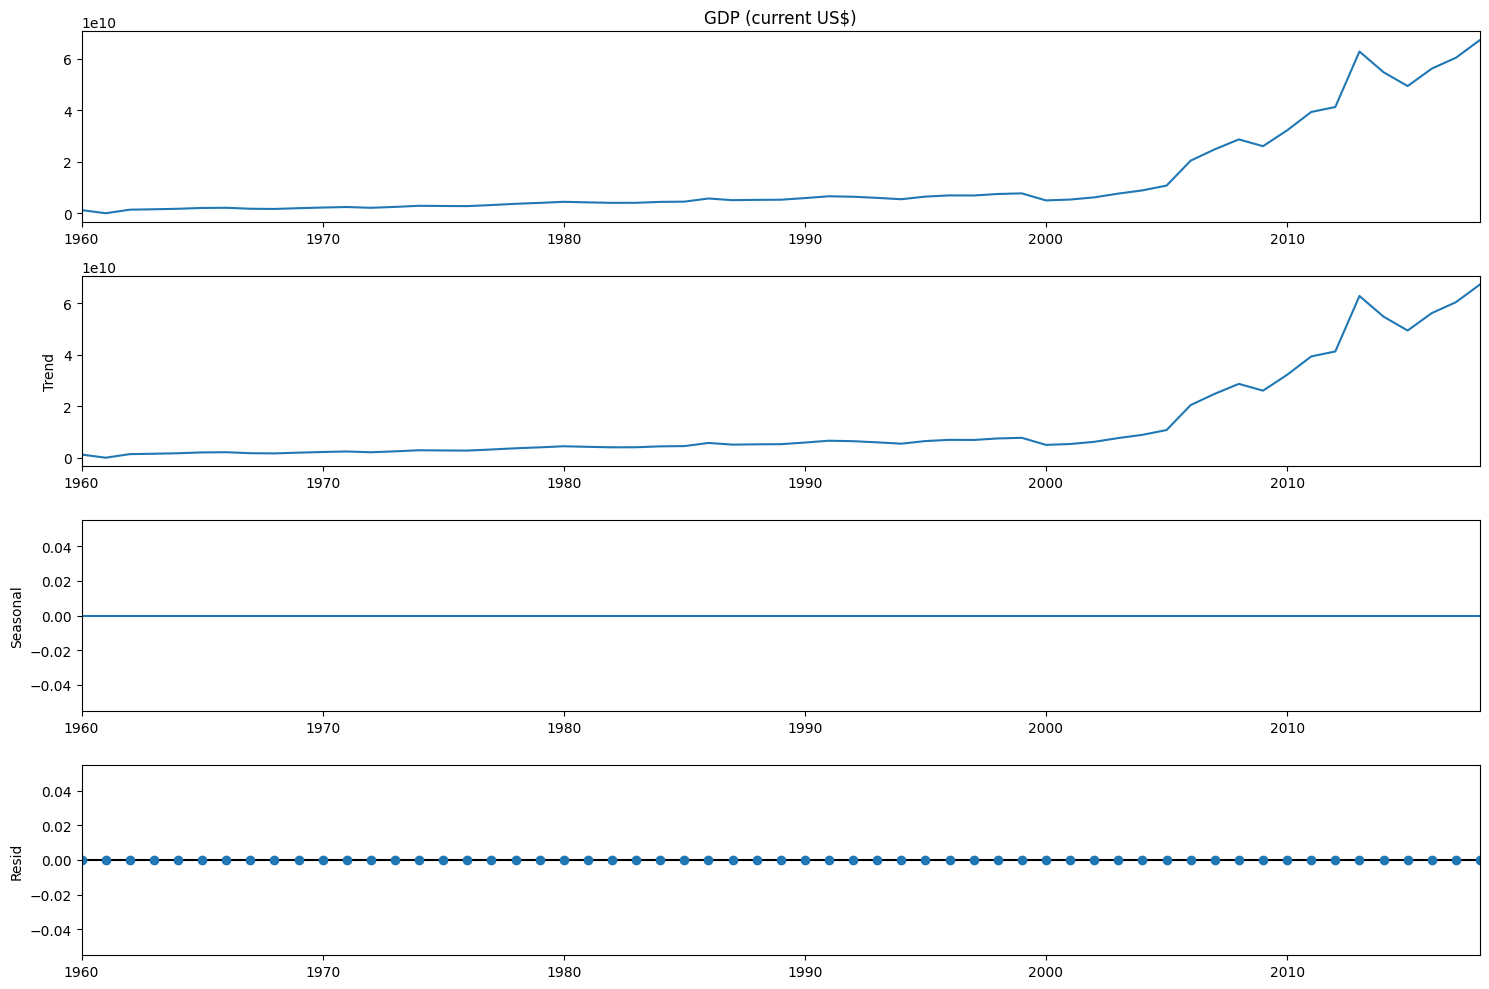

In [5]:
plt.rcParams["figure.figsize"] = 15, 10
result = seasonal_decompose(train['GDP (current US$)'])
result.plot()
plt.show()

Сезонность отсутсвует

Скользящее среднее

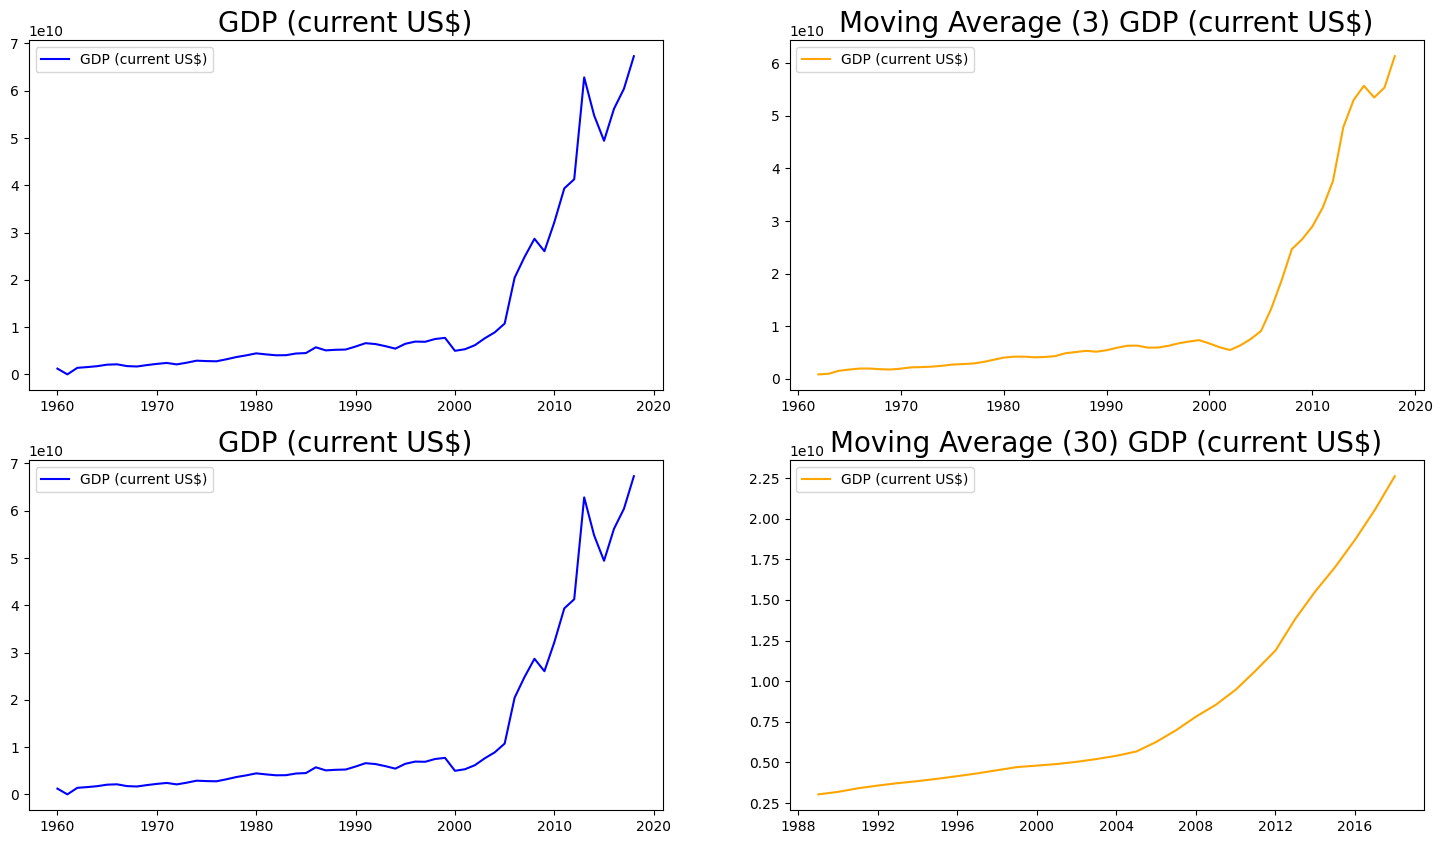

In [6]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train['GDP (current US$)'], color="blue", label="GDP (current US$)")
ax[0, 0].set_title("GDP (current US$)", size=20)
ax[0, 0].legend()

ax[0, 1].plot(
    train['GDP (current US$)'].rolling(window=3).mean(),
    color="orange",
    label="GDP (current US$)",
)

ax[0, 1].set_title("Moving Average (3) GDP (current US$)", size=20)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train['GDP (current US$)'], color="blue", label="GDP (current US$)")
ax[1, 0].set_title("GDP (current US$)", size=20)
ax[1, 0].legend()

ax[1, 1].plot(
    train['GDP (current US$)'].rolling(window=30).mean(),
    color="orange",
    label="GDP (current US$)",
)

ax[1, 1].set_title("Moving Average (30) GDP (current US$)", size=20)
ax[1, 1].legend()

plt.show()

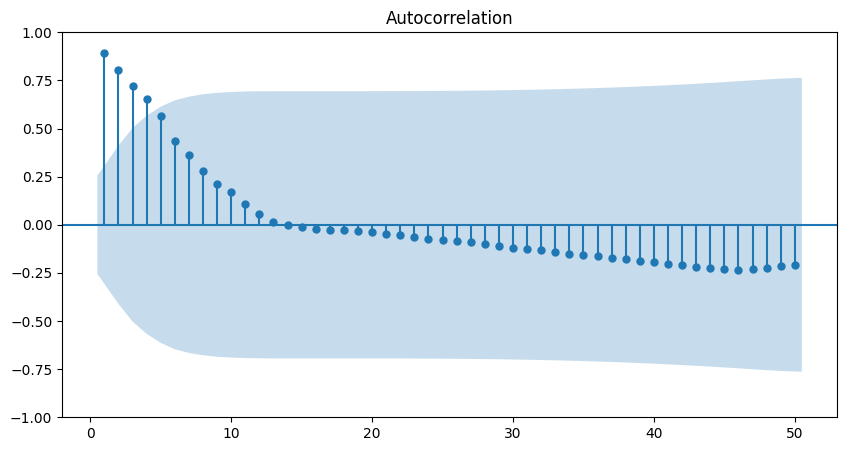

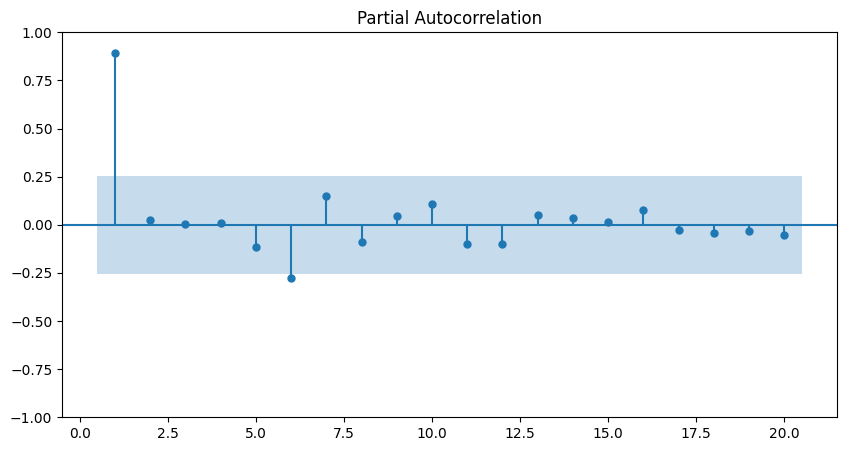

In [7]:
plt.rcParams["figure.figsize"] = 10, 5
sgt.plot_acf(train["GDP (current US$)"], lags=50, zero=False)
sgt.plot_pacf(train["GDP (current US$)"], lags=20, method="ywm", zero=False)
plt.show()

Тест на стационарность

In [8]:
aftest = adfuller(train)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

# Test for first differences
diff1 = train.diff()[1:]
aftest = adfuller(diff1)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

# Test for second differences
diff2 = diff1.diff()[1:]
aftest = adfuller(diff2)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

# Test for third differences
diff3 = diff2.diff()[1:]
aftest = adfuller(diff3)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}')

Statistics: 0.6529066974885349
p_value: 0.9888496277665572
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

Statistics: -1.6702483038320777
p_value: 0.446502932971389
Critical values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}

Statistics: -2.6408690561284898
p_value: 0.08484116917837664
Critical values: {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}

Statistics: -4.779623784828512
p_value: 5.9483276402254376e-05
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


Прогноз ARIMA

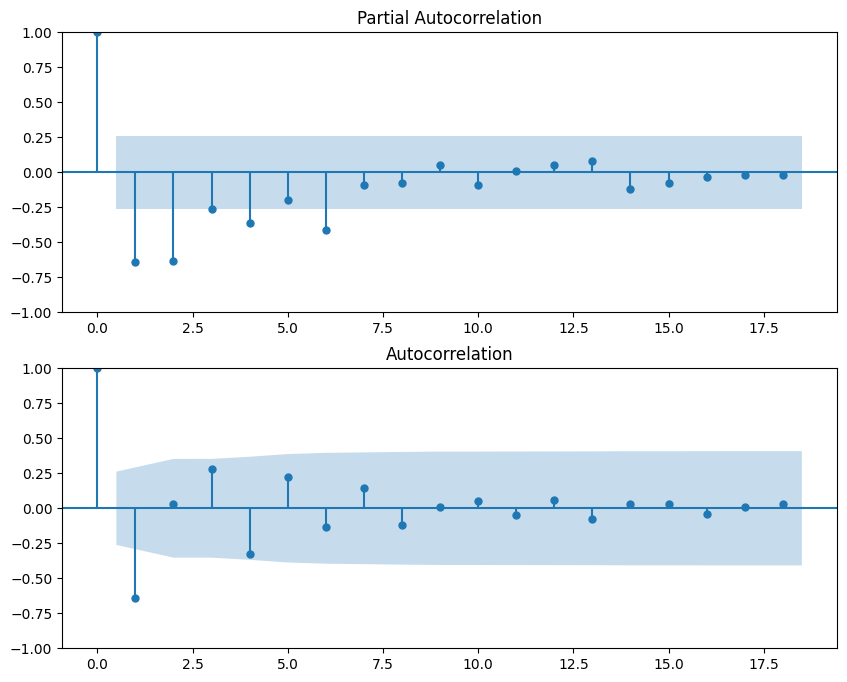

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
tsaplots.plot_pacf(diff3, method='ywm', ax=ax[0])
tsaplots.plot_acf(diff3, ax=ax[1])
plt.show()

Построение модели **ARIMA** со следующими параметрами:

- p = 2 (по частичной автокорреляции)
- d = 3 (интегрированный ряд третьего порядка)
- q = 1 (по автокорреляции)


In [10]:
arima_model = ARIMA(train, order=(2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Mon, 12 Jun 2023   AIC                           2659.231
Time:                        11:39:25   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

Побор лучших параметров с помощью pmdarima.

In [11]:
opt_params = pm.auto_arima(
    train,
    start_p=1, start_q=1,
    max_p=6, max_q=2,
    d=3, stationarity=False, seasonal=False,
    trace=True
)    
opt_params.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.04 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.03 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.04 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.05 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.02 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.585 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Mon, 12 Jun 2023   AIC                           2659.231
Time:                        11:39:26   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

Лучшие параметры не изменились

In [12]:
data["model_preds"] = arima_model_fit.predict(
    start=test.index[0], end=test.index[-1])                                        #Предсказание
forecast = arima_model_fit.get_forecast(len(test.index))
forecast_df = forecast.conf_int(alpha=0.05)                                         #выбор доверитьльного интервала 95%

data.at[test.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
data.at[test.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

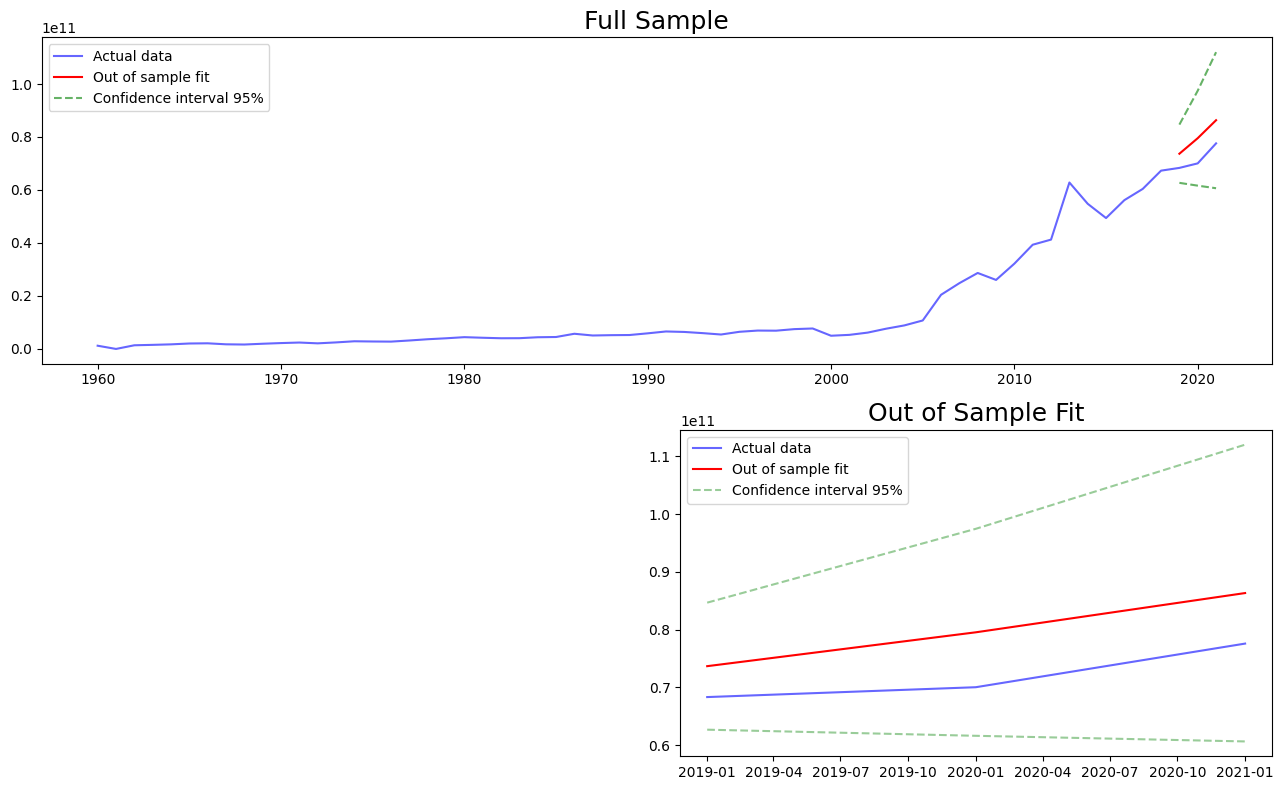

In [13]:
# Визуализаци
plt.figure(figsize=(13, 8))

plt.subplot(2, 1, 1)
plt.plot(data['GDP (current US$)'], color='blue', 
         label='Actual data', alpha=0.6)
plt.plot(data.loc[test.index]['model_preds'], color='red', 
         linestyle='-', label='Out of sample fit')
plt.plot(data.loc[test.index]['model_preds_lower'], color='green', 
         linestyle='--', label='Confidence interval 95%', alpha=0.6)
plt.plot(data.loc[test.index]['model_preds_upper'], color='green', 
         linestyle='--', alpha=0.6)
plt.title('Full Sample', size=18)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(data.loc[test.index]['GDP (current US$)'], color='blue', 
         label='Actual data', alpha=0.6)
plt.plot(data.loc[test.index]['model_preds'], color='red', linestyle='-', 
         label='Out of sample fit')
plt.plot(data.loc[test.index]['model_preds_lower'], color='green', 
         linestyle='--', label='Confidence interval 95%', alpha=0.4)
plt.plot(data.loc[test.index]['model_preds_upper'], color='green', 
         linestyle='--', alpha=0.4)
plt.title('Out of Sample Fit', size=18)
plt.legend()

plt.tight_layout()
plt.show()

Выводы.
1. Построен прогноз по модели ARIMA (авторегрессия со скользящим средним для нестационарного ряда). 
2. Сезонность временного ряда отсутствует. 
3. Ошибки предсказания составляют около 10%, прогноз завышен. 
4. Похоже, что модель в целом ориентировалась на тренд 2014-2018 гг. и пытается описать его продолжение. 
5. Фактические значения не выходят за пределы 95%-го доверительного интервала.

2. Интерполяция и сэмлирование

Проверка на пропущенные значения

In [14]:
data = pd.read_csv('data/ghana_gdp.csv', index_col='year', parse_dates=['year'])
data = data.asfreq(freq='YS')
data.isna().sum()

GDP (current US$)    0
dtype: int64

Проверка на нулевые значения

In [15]:
data[data['GDP (current US$)']==0]

,GDP (current US$)
year,
1961-01-01,0.0


Интерполяция нулевых значений

In [16]:
data.replace(0, np.NaN, inplace=True)
data.interpolate(inplace=True)

Тест на стационарность

In [17]:
# Train / test data
train, test  = data[:-3], data[-3:]

# Augmented Dickey-Fuller unit root test
aftest = adfuller(train)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

# Test for first differences
diff1 = train.diff()[1:]
aftest = adfuller(diff1)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

# Test for second differences
diff2 = diff1.diff()[1:]
aftest = adfuller(diff2)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

# Test for third differences
diff3 = diff2.diff()[1:]
aftest = adfuller(diff3)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}')

Statistics: 0.8030073326980129
p_value: 0.9916845572455877
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

Statistics: -1.8255652246435998
p_value: 0.36784515276563423
Critical values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}

Statistics: -2.634634746007842
p_value: 0.0860481372219768
Critical values: {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}

Statistics: -4.825603687304014
p_value: 4.857318076800112e-05
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


Прогноз ARIMA

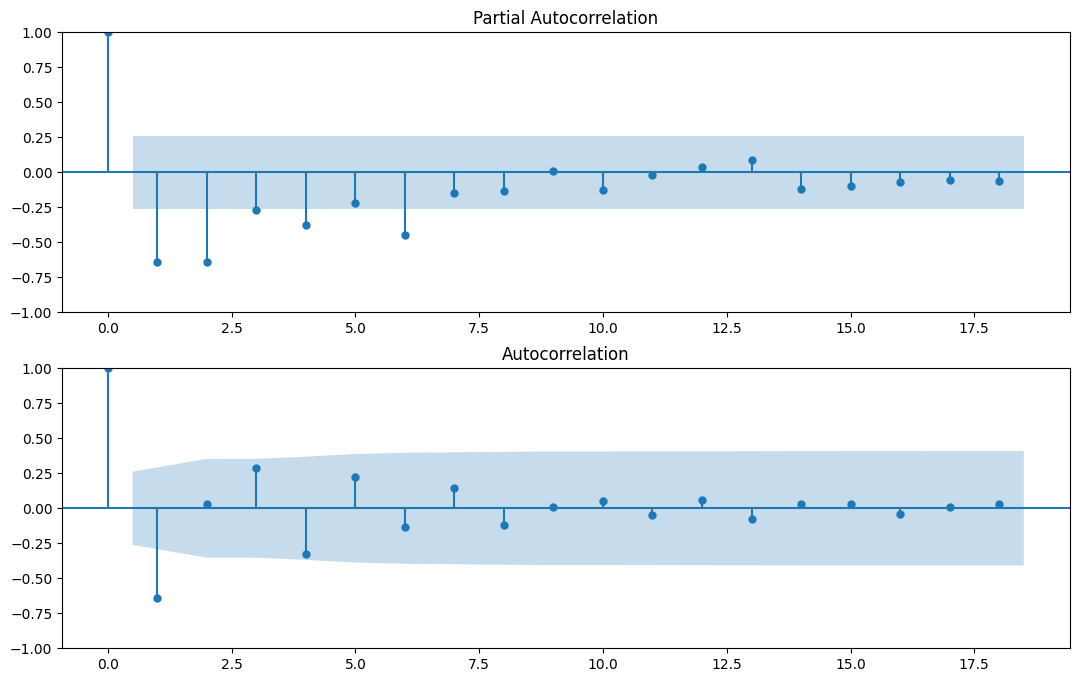

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(13,8))
tsaplots.plot_pacf(diff3, method='ywm', ax=ax[0])
tsaplots.plot_acf(diff3, ax=ax[1])
plt.show()

Параметры ARIMA: p = 2, d = 3, q = 1

In [19]:
model = ARIMA(train, order=(2, 3, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Mon, 12 Jun 2023   AIC                           2659.226
Time:                        11:39:27   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+57. Standard errors may be unstable.
"""

Вывод. 
После замены нулевого значения временного ряда (пропущенные данные 1961 г.) на линейно интерполированное значение критерий AIC уменьшился на небольшую величину (2659.231 -> 2659.226), т.е. качество модели немного улучшилось.

3. Гетероскедастичность

Волатильность

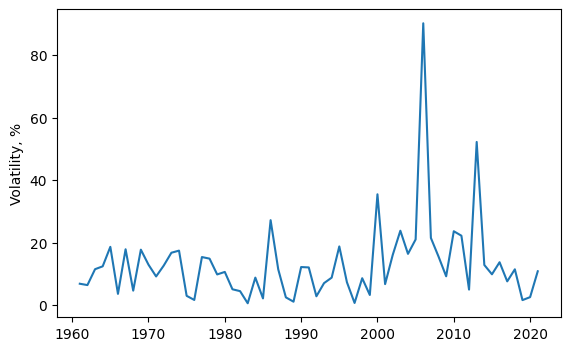

In [20]:
volat = (data.pct_change().abs() * 100)[1:]

plt.figure(figsize=(6.5, 4))
plt.plot(volat)
plt.ylabel('Volatility, %')
plt.show()

Модель GARCH

In [21]:
train, test = volat[:-3], volat[-3:]

# Augmented Dickey-Fuller unit root test
aftest = adfuller(train)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}')

Statistics: -6.725311059553779
p_value: 3.4014596148856493e-09
Critical values: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}


Ряд стационарен

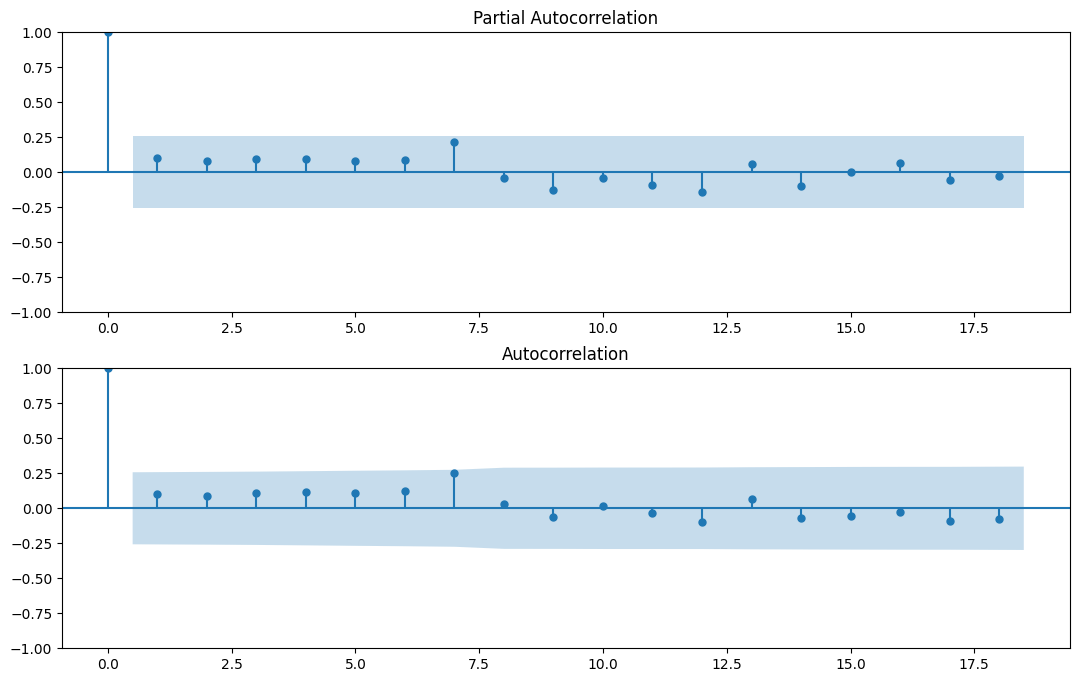

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(13,8))
tsaplots.plot_pacf(train, method='ywm', ax=ax[0])
tsaplots.plot_acf(train, ax=ax[1])
plt.show()

Автокорреляция отсутствует, выбираем минимальные параметры GARCH: p = 1, q = 1

In [23]:
model = arch_model(volat, vol='GARCH', p=1, q=1)
model_results = model.fit(last_obs=train.index[-1], update_freq=5)

garch_pred = model_results.forecast(reindex=False).variance.loc[test.index]

Iteration:      5,   Func. Count:     27,   Neg. LLF: 247.95420470455127
Iteration:     10,   Func. Count:     57,   Neg. LLF: 237.6112987195586
Iteration:     15,   Func. Count:     85,   Neg. LLF: 223.50475325756761
Iteration:     20,   Func. Count:    110,   Neg. LLF: 222.86320785503517
Optimization terminated successfully    (Exit mode 0)
            Current function value: 222.86320785503517
            Iterations: 20
            Function evaluations: 110
            Gradient evaluations: 20


Линейная регрессия

In [24]:
X_train = np.array(range(train.shape[0])).reshape(-1, 1)
y_train = train.values[:, 0]
X_test = np.array(range(
    train.shape[0], train.shape[0] + test.shape[0])).reshape(-1, 1)
y_test = test.values[:, 0]

regr = LinearRegression()
regr.fit(X_train, y_train)
regr_pred = regr.predict(X_test)
regr_pred = pd.Series(regr_pred, index=test.index)

Сравнение результатов

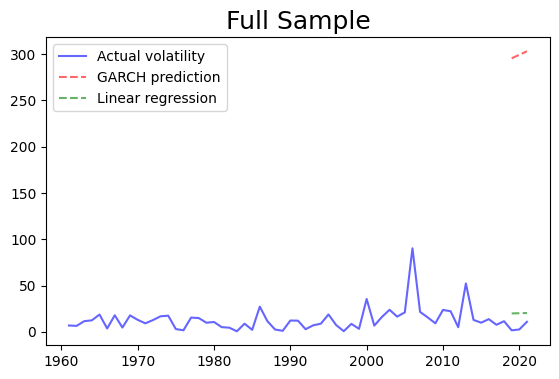

In [25]:
plt.figure(figsize=(6.5, 4))
plt.plot(volat, color='blue', label='Actual volatility', alpha=0.6)
plt.plot(garch_pred, color='red', linestyle='--', 
         label='GARCH prediction', alpha=0.6)
plt.plot(regr_pred, color='green', linestyle='--', 
         label='Linear regression', alpha=0.6)
plt.title('Full Sample', size=18)
plt.legend()
plt.show()

Выводы.
1. Модель GARCH показывает значительное расхождение с фактическими значениями волатильности. 
2. Из автокорреляционных функций видно, что автокорреляция для волатильности в представленном ряде отсутствует, т.е., вообще говоря, модель GARCH в данном случае неприменима, т.к. предыдущие значения ряда не влияют/слабо влияют на последующие. 
3. Простая линейная регрессия показала в данном случае более правдоподобный прогноз.
